# Построение моделей для решения задачи классификации (бинарная)

Импорт необходимых библиотек

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

Загрузка датасета

Целевой признак - bomb_planted

In [60]:
data = pd.read_csv('csgo_filtred.csv')

y = data['bomb_planted']
X = data.drop(columns=['bomb_planted'], axis=1)

# Проверка баланса классов

In [61]:
X.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,health_lead,armor_lead,money_lead,helmets_lead,players_alive_lead
0,175.00,0,0,de_dust2,500,500,0,0,4000,4000,0,0,0,5,5,2,2,2,2,2
1,156.03,0,0,de_dust2,500,500,400,300,600,650,0,0,1,5,5,2,0,1,2,2
2,96.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
3,76.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
4,174.97,1,0,de_dust2,500,500,192,0,18350,10750,0,0,1,5,5,2,0,0,2,2


<Axes: ylabel='bomb_planted'>

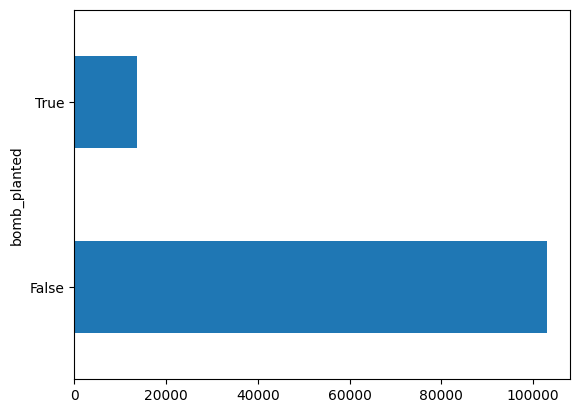

In [62]:
y.value_counts().plot.barh()

In [63]:
y.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

Видно, что классы максимально несбалансированы, количество класса false превосходит класс true более чем в 5 раз.

Для балансировки буду использовать метод SMOTE, он создаёт дополнительные точки для минаритарного класса, основываясь на уже существующих точках.

Но для начала преобразую переменные признака map в числовые.

In [64]:
X['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [65]:
X['map'] = X['map'].str.strip().str.lower()

In [66]:
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

In [67]:
oversample = SMOTE()
transformed_X, tranformed_y = oversample.fit_resample(X, y)

In [68]:
print(f'OLD: {y.value_counts()}')
print()
print(f'NEW: {tranformed_y.value_counts()}')

OLD: bomb_planted
False    102945
True      13684
Name: count, dtype: int64

NEW: bomb_planted
False    102945
True     102945
Name: count, dtype: int64


In [69]:
X, y = transformed_X, tranformed_y

In [70]:
X.duplicated().sum()

np.int64(0)

Как можно увидеть балансировка по классам получилась успешной, теперь мы имеем два класса с одинаковым количеством точек.

# Разделение на тренировочную и тестовую выборки

In [71]:
# Метод train_test_split с использованием stratify

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((164712, 20), (164712,), (41178, 20), (41178,))

In [72]:
# KFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Обучение моделей

In [73]:
def metrics(pred_array, true_array=y_test,):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

In [74]:
# Logistic Regression

model = LogisticRegression(max_iter=500)
# Hold-out
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics(y_pred)
# CV
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
print(f'Оценка кросс-валидации: {scores.mean()}')

F1: 0.9535243076191608
accuracy: 0.9525231919957259
precision: 0.9338331160365059
recall: 0.9740638204866676
roc_auc_score: 0.9525231919957259
Оценка кросс-валидации: 0.9524165215908198


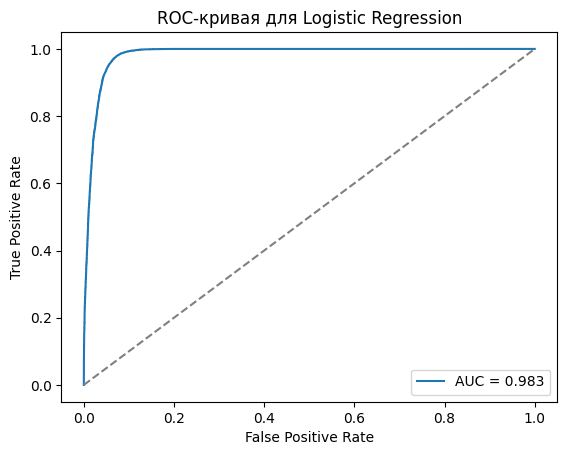

In [77]:
y_prob = model.predict_proba(X_test)[:, 1]

# Считаем ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Logistic Regression')
plt.legend(loc='lower right')
plt.show()


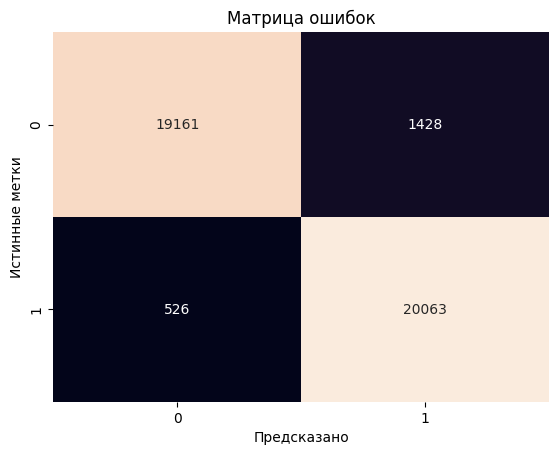

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Предсказания на тесте
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Предсказано')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()


In [ ]:
# KNN

model = KNeighborsClassifier()
# Hold-out
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics(y_pred)
# CV
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
print(f'Оценка кросс-валидации: {scores.mean()}')

F1: 0.9512505298855447
accuracy: 0.9497304385837098
precision: 0.9233301330407352
recall: 0.9809121375491767
confusion_matrix: [[18912  1677]
 [  393 20196]]
roc_auc_score: 0.9497304385837098
Оценка кросс-валидации: 0.9467162952138309
